In [1]:
import os
import math
import time
import pandas as pd
import numpy as np
import imageio
import statistics
import matplotlib.pyplot as plt
from numpy import log as ln
from numpy import exp
from scipy.special import factorial
import scipy.optimize as spo 
from scipy.stats import linregress
from scipy.stats import norm
from scipy.stats import poisson
from itertools import zip_longest
from itertools import combinations_with_replacement
from itertools import permutations
from datetime import datetime  
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D





folder = os.path.abspath('Experimental_data') 
data = {}
R= 8.31/1000 #[kJ/mol]


def s0(T):
        if T !=0:
            t=T/1000
            A = 33.066178
            B = -11.363417
            C = 11.432816
            D = -2.772874
            E = -0.158558
            G = 172.707974
            S0 = A*ln(t) + B*t + C*(t**2)/2 + D*(t**3)/3 - E/(2*t**2) + G # Hydrogen standard entropy J/mol of H2- NIST
            S0 = S0/1000 #kJ/mol of H2
            return S0
        else:
            return 0          
        
        
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier


# Simulation BCC Lattice - Tetrahedral sites occupation

In [2]:
###################################### SIMULATION TETRAHEDRAL BCC STRUCTURE ########################3
name = 'positions'
if not os.path.isdir(os.getcwd() + f'/JMAK/{name}'): #Verify if the folder exists
    os.mkdir(os.getcwd() + f'/JMAK/{name}')          #creates the folder is it not exists
       
my_path = os.path.abspath(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}')

inicio_tot = time.time()
data_f_T_BCC ={}
neighbors = [np.sqrt(2)/4,1/2,np.sqrt(6)/4]
sites_occupied = {}
sites_blocked = {}
sites_available = {}
for NN in neighbors:
    inicio = time.time()
    sites_i=np.zeros(3)
    sites_b=np.zeros(3)
    total_sites=[]
    sites_v_temp = []
    occupancy = {}
    sites_occupied[NN] = {}
    sites_blocked[NN] = {}
    sites_available[NN] = {}

    wyckoff_positions = []
    wyckoff_positions_1 = [0,1/2,1/4]
    wyckoff_positions_2=  [0,1/2,3/4]
    wyckoff_positions = wyckoff_positions+ list(permutations(wyckoff_positions_1,3)) + list(permutations(wyckoff_positions_2,3)) 
    wyckoff_positions = np.array(wyckoff_positions)
    sites_v_temp = wyckoff_positions
    x_cells = np.arange(27)
    y_cells = np.arange(27)
    z_cells = np.arange(28)
    for k in z_cells:
        for j in y_cells:
            for i in x_cells:
                if (i,j,k)!=(0,0,0):
                    sites_v_temp= np.append(sites_v_temp,wyckoff_positions+(i,j,k),axis=0)    


    total_sites = sites_v_temp
    sites_v_temp = np.array(sites_v_temp)
    while len(sites_v_temp)>0:
        idx = np.random.randint(0,len(sites_v_temp))
        sites_i = np.vstack((sites_i,np.array(sites_v_temp[idx])))
        actual_site = sites_v_temp[idx]
        sites_v_temp = np.delete(sites_v_temp,idx,axis=0)
        blocked_idx = np.argwhere(np.sqrt(np.sum((sites_v_temp-actual_site)**2,axis=1))<=NN)
        if len(blocked_idx) >0:
            blocked = np.concatenate(np.take(sites_v_temp,blocked_idx,axis=0),axis=0)
            sites_b = np.vstack((sites_b,blocked))
            sites_v_temp= np.delete(sites_v_temp,blocked_idx,axis=0)
        occupancy[len(sites_i[1:])/len(total_sites)] = [len(sites_b[1:])/len(total_sites),len(sites_v_temp)/len(total_sites)]
        
        if len(sites_i[1:])%(54*4)==0:
            sites_occupied[NN][len(sites_i[1:])/len(total_sites)]= sites_i[1:]
            sites_blocked[NN][len(sites_i[1:])/len(total_sites)]= sites_b[1:]
            sites_available[NN][len(sites_i[1:])/len(total_sites)]= sites_v_temp

            if not os.path.isdir(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/occupied'): #Verify if the folder exists
                os.mkdir(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/occupied')          #creates the folder is it not exists

            my_path = os.path.abspath(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/occupied')
            my_file = f'sites_occupied_fi{len(sites_i[1:])/len(total_sites)}.txt' #structure.name[0]
            dataframe = pd.DataFrame(sites_occupied[NN][len(sites_i[1:])/len(total_sites)])
            dataframe = dataframe.rename(columns = { 0 : "x", 1 : "y", 2: "z"})
            dataframe.to_csv(os.path.join(my_path, my_file), sep = '\t', encoding = "utf-8", index = False, columns=['x', 'y','z'])

            if not os.path.isdir(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/blocked'): #Verify if the folder exists
                os.mkdir(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/blocked')          #creates the folder is it not exists

            my_path = os.path.abspath(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/blocked')
            my_file = f'sites_blocked_fi{len(sites_i[1:])/len(total_sites)}.txt' #structure.name[0]
            dataframe = pd.DataFrame(sites_blocked[NN][len(sites_i[1:])/len(total_sites)])
            dataframe = dataframe.rename(columns = { 0 : "x", 1 : "y", 2: "z"})
            dataframe.to_csv(os.path.join(my_path, my_file), sep = '\t', encoding = "utf-8", index = False, columns=['x', 'y','z'])

            if not os.path.isdir(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/available'): #Verify if the folder exists
                os.mkdir(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/available')          #creates the folder is it not exists

            my_path = os.path.abspath(f'/media/dell/Arquivos/Documentos/Otavio/JMAK/{name}/available')        

            my_file = f'sites_available_fi{len(sites_i[1:])/len(total_sites)}.txt' #structure.name[0]
            dataframe = pd.DataFrame(sites_available[NN][len(sites_i[1:])/len(total_sites)])
            dataframe = dataframe.rename(columns = { 0 : "x", 1 : "y", 2: "z"})
            dataframe.to_csv(os.path.join(my_path, my_file), sep = '\t', encoding = "utf-8", index = False, columns=['x', 'y','z'])



    f_i = list(occupancy.keys())
    f_b = [occupancy[f_i][0] for f_i in occupancy.keys() ]
    f_v= [occupancy[f_i][1] for f_i in occupancy.keys() ]
    print(NN,len(total_sites),len(sites_i[1:]),len(sites_b[1:]),len(sites_v_temp), len(sites_i[1:])+len(sites_b[1:]))
    data_f_T_BCC[NN]=[f_i,f_b,f_v,sites_i,sites_b,total_sites]
    fim = time.time()

    tempo_decorrido = fim - inicio
    print("Iteration time:", tempo_decorrido/60, "minutes")

fim_tot = time.time()

tempo_decorrido = fim_tot - inicio_tot
print("Total time:", tempo_decorrido/60, "minutes")

0.3535533905932738 244944 87204 157740 0 244944
Iteration time: 7.335532867908478 minutes
0.5 244944 55372 189572 0 244944
Iteration time: 5.134844934940338 minutes
0.6123724356957945 244944 33833 211111 0 244944
Iteration time: 2.9250019907951357 minutes
Total time: 15.395392481486002 minutes


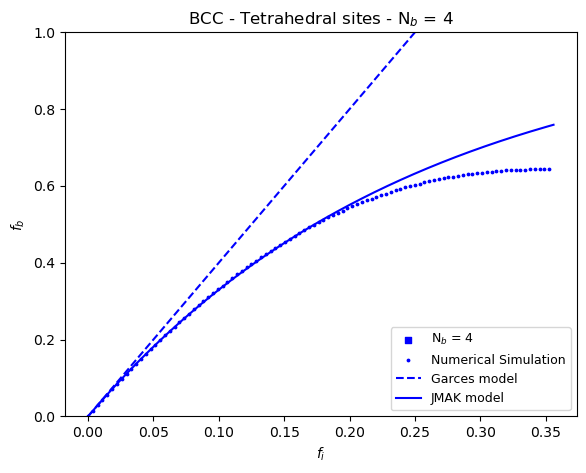

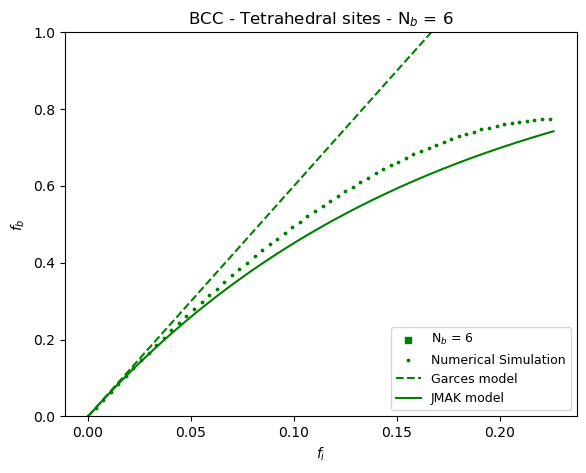

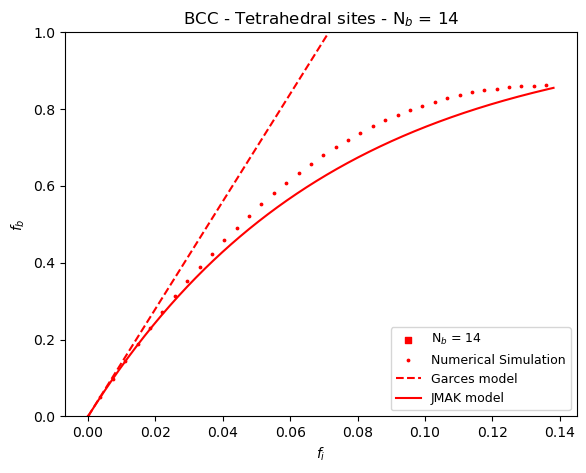

In [93]:
from scipy.optimize import curve_fit
def JMAK_BCC_T(x,Nb):
    return 1-exp(-Nb*x)

if not os.path.isdir(os.getcwd() +'/Comparison'): #Verify if the folder exists
    os.mkdir(os.getcwd() +'/Comparison')          #creates the folder is it



my_path = os.getcwd() +'/Comparison'    

    
co = ['blue','green','red']
i=0
for NN in data_f_T_BCC.keys():
    
    if NN==np.sqrt(2)/4:
        JMAK_nb=4 #nb = 2
    if NN==1/2:
        JMAK_nb = 6 # nb = 4
    if NN==np.sqrt(6)/4:
        JMAK_nb= 14

    nb = JMAK_nb
    
    f_i= np.array(data_f_T_BCC[NN][0])
    f_b= data_f_T_BCC[NN][1]
    
    
    my_file = f'fb_BCC_T_{nb}'
    fig = plt.figure()

    # Add set of axes to figure
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    
      

    #plot JMAK model
    
    axes.plot(f_i,JMAK_BCC_T(f_i,nb), color = co[i])
    
    #plot Garces Model
    axes.plot(f_i,nb*f_i, linestyle='--', color=co[i])#, label = f'f$_b$ - Garces model - n$_b$ = {nb}')
    
    #plot Numerical simulation results
    x=np.array([data_f_T_BCC[NN][0][idx] for idx in range(0,len(data_f_T_BCC[NN][0]),900)])
    y=np.array([data_f_T_BCC[NN][1][idx] for idx in range(0,len(data_f_T_BCC[NN][1]),900)])
        
    axes.scatter(x,y,s=3,color=co[i]) 
    axes.scatter([],[],s=15, color=co[i], marker = 's', label = f'N$_b$ = {nb}')
    axes.scatter([],[],s=3, color = co[i], label = f'Numerical Simulation')
    axes.plot([],[],linestyle ='--', color = co[i], label = f'Garces model')
    axes.plot([],[], color = co[i], label = f'JMAK model')
    axes.set_ylabel(f'$f_b$')
    axes.set_xlabel(f'$f_i$')
    axes.set_ylim([0,1])
    axes.set_title(f'BCC - Tetrahedral sites - N$_b$ = {nb}')
    axes.legend(loc=4,ncol=1, fontsize = 9)
    i=i+1
    fig.savefig(os.path.join(my_path, my_file), dpi=200, bbox_inches='tight')


# Counting Sites

In [6]:
#######################CONTAGEM CERTA!!!!!!!!!!!!!!!!!!!
inicio_tot = time.time()
count_blocked ={}
count_occupied ={}
count_available ={}
count_nonblocked ={}
for NN in neighbors:
    count_blocked[NN] ={}
    count_occupied[NN] ={}
    count_available[NN] ={}
    count_nonblocked[NN] ={}

sites = [sites_blocked[NN],sites_occupied[NN],sites_available[NN]]
counts = [count_blocked[NN],count_occupied[NN],count_available[NN]]

n_cells_X=np.arange(5)
n_cells_y=np.arange(5)
n_cells_z=np.arange(5)

sites_temp= np.array([[0,0,0]])
for k in n_cells_z:
        for j in n_cells_y:
            for i in n_cells_X:
                if (i,j,k)!=(0,0,0):
                    sites_temp= np.append(sites_temp,np.array([[i,j,k]]),axis=0) 

for NN in neighbors:
    reg = False
    for fi in list(sites_occupied[NN]):
        count_blocked[NN][fi] = {}
        count_occupied[NN][fi] = {}
        count_available[NN][fi] = {}
        count_nonblocked[NN][fi] = {}

        for it in range(1000):

            idx1 = np.random.randint(0,len(x_cells))
            idx2 = np.random.randint(0,len(y_cells))
            idx3 = np.random.randint(0,len(z_cells))


            if x_cells[idx1]+len(n_cells_X)< len(x_cells):
                x_lower_bound = x_cells[idx1]
                x_upper_bound = x_cells[idx1]+len(n_cells_X)
            if x_cells[idx1]+len(n_cells_X) >len(x_cells):
                x_upper_bound = x_cells[idx1]
                x_lower_bound = x_cells[idx1]-len(n_cells_X)



            if y_cells[idx2]+len(n_cells_y) <len(y_cells):
                y_lower_bound = y_cells[idx2]
                y_upper_bound = y_cells[idx2]+len(n_cells_y) 
            if y_cells[idx2]+len(n_cells_y) >len(y_cells):
                y_upper_bound = y_cells[idx2]
                y_lower_bound = y_cells[idx2]-len(n_cells_y)



            if z_cells[idx3]+len(n_cells_z)<len(y_cells):
                z_lower_bound = z_cells[idx3]
                z_upper_bound = z_cells[idx3]+len(n_cells_z)
            if z_cells[idx3]+len(n_cells_z)>len(z_cells):
                z_upper_bound = z_cells[idx3]
                z_lower_bound = z_cells[idx3]-len(n_cells_y)


            #if np.any((x_lower_bound<x_upper_bound,y_lower_bound<y_upper_bound,z_lower_bound<z_upper_bound)==False):
            #print(x_lower_bound,x_upper_bound,y_lower_bound,y_upper_bound,z_lower_bound,z_upper_bound)

            arr= sites_blocked[NN][fi]
            if (x_lower_bound<x_upper_bound):
                x_mask = (arr[:, 0] >= x_lower_bound) & (arr[:, 0] < x_upper_bound)


            if (y_lower_bound<y_upper_bound):
                y_mask = (arr[:, 1] >= y_lower_bound) & (arr[:, 1] < y_upper_bound)


            if (z_lower_bound<z_upper_bound):
                z_mask = (arr[:, 2] >= z_lower_bound) & (arr[:, 2] < z_upper_bound)


            values_within_ranges = arr[x_mask & y_mask & z_mask]
            count_blocked[NN][fi][it]=len(values_within_ranges)



            arr= sites_occupied[NN][fi]
            if (x_lower_bound<x_upper_bound):
                x_mask = (arr[:, 0] >= x_lower_bound) & (arr[:, 0] < x_upper_bound)

            if (y_lower_bound<y_upper_bound):
                y_mask = (arr[:, 1] >= y_lower_bound) & (arr[:, 1] < y_upper_bound)


            if (z_lower_bound<z_upper_bound):
                z_mask = (arr[:, 2] >= z_lower_bound) & (arr[:, 2] < z_upper_bound)


            values_within_ranges = arr[x_mask & y_mask & z_mask]
            count_occupied[NN][fi][it]=len(values_within_ranges)


            arr= sites_available[NN][fi]
            if (x_lower_bound<x_upper_bound):
                x_mask = (arr[:, 0] >= x_lower_bound) & (arr[:, 0] < x_upper_bound)

            if (y_lower_bound<y_upper_bound):
                y_mask = (arr[:, 1] >= y_lower_bound) & (arr[:, 1] < y_upper_bound)

            if (z_lower_bound<z_upper_bound):
                z_mask = (arr[:, 2] >= z_lower_bound) & (arr[:, 2] < z_upper_bound)


            values_within_ranges = arr[x_mask & y_mask & z_mask]
            count_available[NN][fi][it]=len(values_within_ranges)
            count_nonblocked[NN][fi][it] = count_available[NN][fi][it] +count_occupied[NN][fi][it]
fim_tot = time.time()

tempo_decorrido = fim_tot - inicio_tot
print("Total time:", tempo_decorrido/60, "minutes")

Total time: 24.854482209682466 minutes


# Distribution of non blocked sites

In [58]:
# Gifs for Nb = 4, 6, and 14

    
for NN in neighbors:    
    if NN==np.sqrt(2)/4:
        JMAK_nb=4 #nb = 2
    if NN==1/2:
        JMAK_nb = 6 # nb = 4
    if NN==np.sqrt(6)/4:
        JMAK_nb= 14
    
    def create_frame(t):

        # Dicionário de exemplo
        dicionario = count_nonblocked[NN][t]

        # Extrair os valores do dicionário
        valores = list(dicionario.values())
        fig = plt.figure()

            # Add set of axes to figure
        axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

        # Plotar o histograma
        axes.hist(np.array(valores), bins=max(valores)-min(valores)+1, edgecolor='black', density = True)
        # creating a numpy array for x-axis
        x = np.arange(0, (len(n_cells_X)*len(n_cells_y)*len(n_cells_z)*12), 0.5)
        
        l=sum(valores)/1000
        #poisson distribution data for y-axis
        
        yNP= norm.pdf(x, l, np.sqrt(l))
        axes.plot(x,yNP,c='red') #Aproximation - Poisson as Normal with average = lambda, and standard deviation as sqrt(lambda)
        #one can verify as this aproximation results in equal plots turning on the lines below
        #y = poisson.pmf(x, mu=l) 
        #axes.plot(x,y, c='green')

        
        
        plt.xlabel('number of non blocked sites')
        plt.ylabel('Probability')
        plt.ylim(0,0.1)
        plt.xlim(0,(len(n_cells_X)*len(n_cells_y)*len(n_cells_z)*12))
        plt.title(f'f$_i$ = {t}')
        axes.grid(True)

        return fig
    
    frames = []

    #create frames separately as .png files
    for t in list(count_nonblocked[NN])[15::15]:
        fig = create_frame(t)
        filename = f'frame_dist_{t:.3f}.png'
        fig.savefig(filename)
        frames.append(imageio.imread(filename))
        plt.close(fig)

    # combine frames in a gif
    imageio.mimsave(f'animation_poisson_dist_nonblock_nb{JMAK_nb}.gif', frames,duration=1000/2)  # Altere a duração conforme necessário

    # Remove frames .png files
    import os
    for filename in os.listdir():
        if filename.startswith('frame_') and filename.endswith('.png'):
            os.remove(filename)

/tmp/ipykernel_15099/3025422514.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))


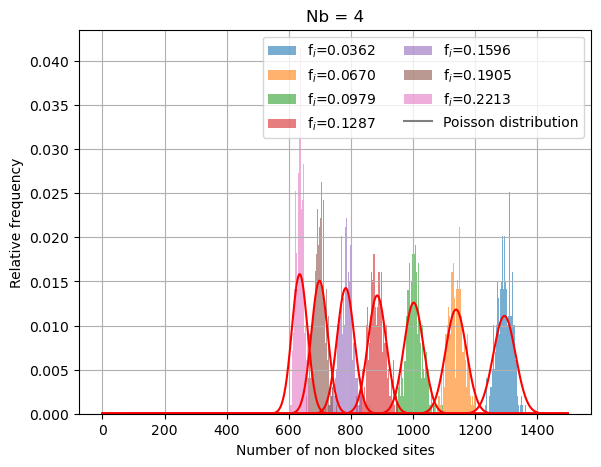

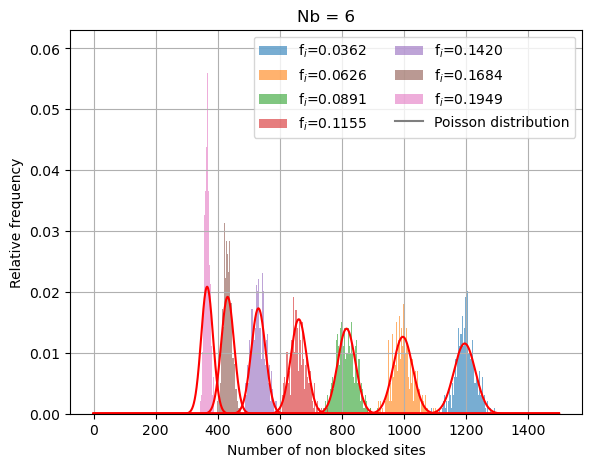

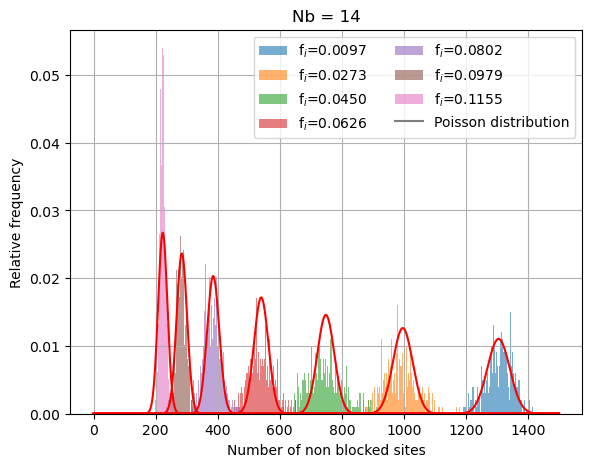

In [48]:
#images for Nb = 4, 6, and 14



    
for NN in neighbors:    
    if NN==np.sqrt(2)/4:
        JMAK_nb=4 #nb = 2
        lim_inf=40
        lim_sup = len(count_blocked[NN])-120
        step=35
    if NN==1/2:
        JMAK_nb = 6 # nb = 4
        lim_inf=40
        lim_sup = len(count_blocked[NN])-20
        step=30
    if NN==np.sqrt(6)/4:
        JMAK_nb= 14
        lim_inf=10
        lim_sup = len(count_blocked[NN])-20
        step=20
        
    def funcao(fi):
        return exp(-JMAK_nb*fi)
    

    
    frames = []
    filename = f'distributions_nonblocked_nb{JMAK_nb}.png'
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    #fig = create_frame(t)
    x = np.arange(0, (len(n_cells_X)*len(n_cells_y)*len(n_cells_z)*12), 0.5)
    
    for fi in list(count_nonblocked[NN])[lim_inf:lim_sup:step]:
        dicionario = count_nonblocked[NN][fi]
        valores = list(dicionario.values())
        axes.hist(np.array(valores), bins=max(valores)-min(valores)+1,density=True,label=f'f$_i$={fi:.4f}',alpha=0.6)
        
        l=sum(valores)/1000
        #poisson distribution data for y-axis 
        yNP= norm.pdf(x, l, np.sqrt(l)) #Aproximation - Poisson as Normal with average = lambda, and standard deviation as sqrt(lambda)
        #one can verify as this aproximation results in equal plots turning on the lines below
        #y = poisson.pmf(x, mu=l) 
        #axes.plot(x,y, c='green')
        axes.plot(x,yNP,c='red')
   
    plt.plot([],[],label='Poisson distribution')    
    plt.xlabel('Number of non blocked sites')
    plt.ylabel('Relative frequency')
    plt.title(f'Nb = {JMAK_nb}')
    plt.legend(loc=0,ncol=2)
    axes.grid(True)
    fig.savefig(filename)


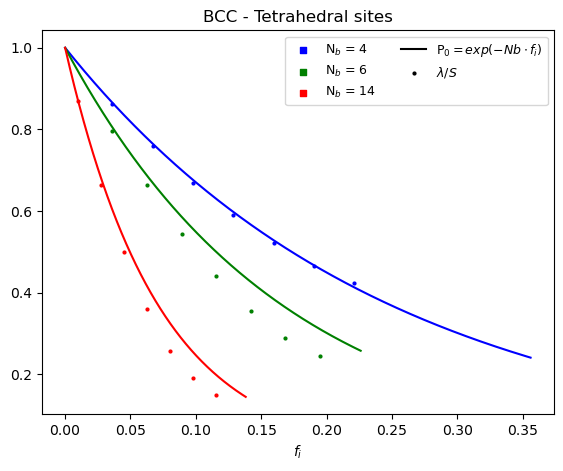

In [116]:
from scipy.optimize import curve_fit
def JMAK_P0(x,Nb):
    return exp(-Nb*x)

    
x1={}
y1={}    
co = ['blue','green','red']
i=0

    
my_file = f'Comparison_nb'
fig = plt.figure()

# Add set of axes to figure
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
for NN in data_f_T_BCC.keys():
    if NN==np.sqrt(2)/4:
        JMAK_nb=4 #nb = 2
        lim_inf=40
        lim_sup = len(count_blocked[NN])-120
        step=35
    if NN==1/2:
        JMAK_nb = 6 # nb = 4
        lim_inf=40
        lim_sup = len(count_blocked[NN])-20
        step=30
    if NN==np.sqrt(6)/4:
        JMAK_nb= 14
        lim_inf=10
        lim_sup = len(count_blocked[NN])-20
        step=20

    nb = JMAK_nb
    
    f_i= np.array(data_f_T_BCC[NN][0])
    f_b= data_f_T_BCC[NN][1]
    
    
    x1[NN]=[]
    y1[NN]=[]
    for fi in list(count_nonblocked[NN])[lim_inf:lim_sup:step]:
        dicionario = count_nonblocked[NN][fi]
        valores = list(dicionario.values())
        y1[NN].append(sum(valores)/(1000)/(len(n_cells_X)*len(n_cells_y)*len(n_cells_z)*12))
        x1[NN].append(fi)
    
    
    

    
      

    #plot P0= exp(-Nbfi)
    
    axes.plot(f_i,JMAK_P0(f_i,nb), color = co[i])
    
    
    #plot Numerical results from Poisson obtained from simulation    
    axes.scatter(x1[NN],y1[NN],s=4,color = co[i])
   
    #Colors legend for Nb = 4, 6, and 14
    axes.scatter([],[],s=15, color=co[i], marker = 's', label = f'N$_b$ = {nb}')
    i=i+1

axes.plot([],[], color = 'black', label = f'P$_0=exp(-Nb \cdot f_i)$')
axes.scatter([],[],s=4, color = 'black', label = f'$\lambda/S$')
axes.set_xlabel(f'$f_i$')
axes.set_title(f'BCC - Tetrahedral sites')
axes.legend(loc=0,ncol=2, fontsize = 9)
fig.savefig(my_file, dpi=200, bbox_inches='tight')

# Distributions occupied, available, and blocked sites

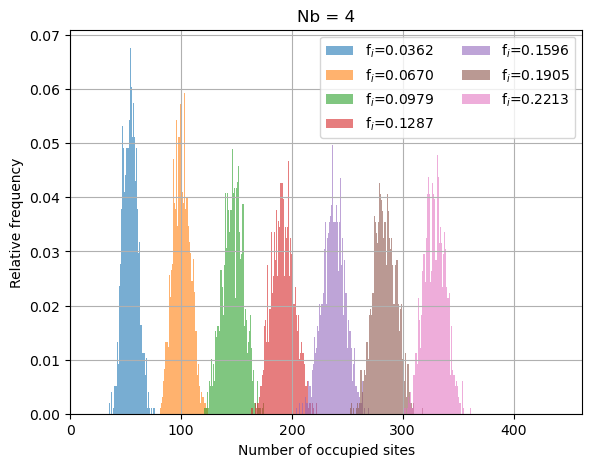

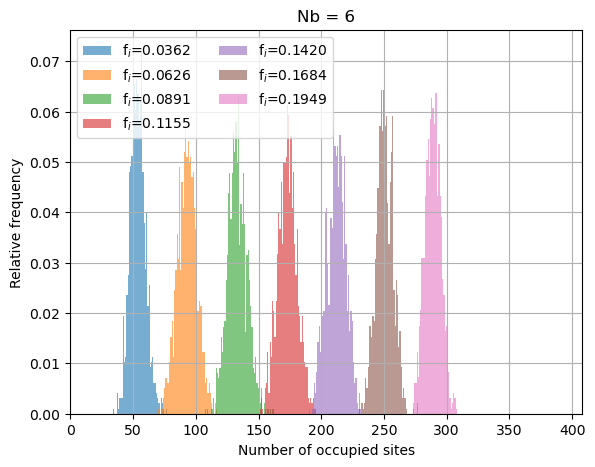

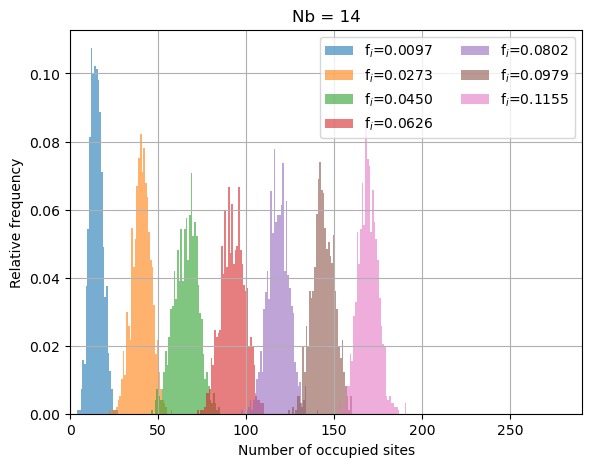

In [63]:
#Occupied



    
for NN in neighbors:    
    if NN==np.sqrt(2)/4:
        JMAK_nb=4 #nb = 2
        lim_inf=40
        lim_sup = len(count_blocked[NN])-120
        step=35
    if NN==1/2:
        JMAK_nb = 6 # nb = 4
        lim_inf=40
        lim_sup = len(count_blocked[NN])-20
        step=30
    if NN==np.sqrt(6)/4:
        JMAK_nb= 14
        lim_inf=10
        lim_sup = len(count_blocked[NN])-20
        step=20
        
    def funcao(fi):
        return exp(-JMAK_nb*fi)
    
    
    frames = []
    filename = f'distributions_occupied_nb{JMAK_nb}.png'
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    x = np.arange(0, (len(n_cells_X)*len(n_cells_y)*len(n_cells_z)*12), 0.5)
    
    for fi in list(count_occupied[NN])[lim_inf:lim_sup:step]:
        dicionario = count_occupied[NN][fi]
        valores = list(dicionario.values())
        axes.hist(np.array(valores), bins=max(valores)-min(valores)+1,density=True,label=f'f$_i$={fi:.4f}',alpha=0.6)


    plt.xlabel('Number of occupied sites')
    plt.ylabel('Relative frequency')
    plt.xlim(0,max(valores)+100)
    plt.title(f'Nb = {JMAK_nb}')
    plt.legend(loc=0,ncol=2)
    axes.grid(True)
    fig.savefig(filename)


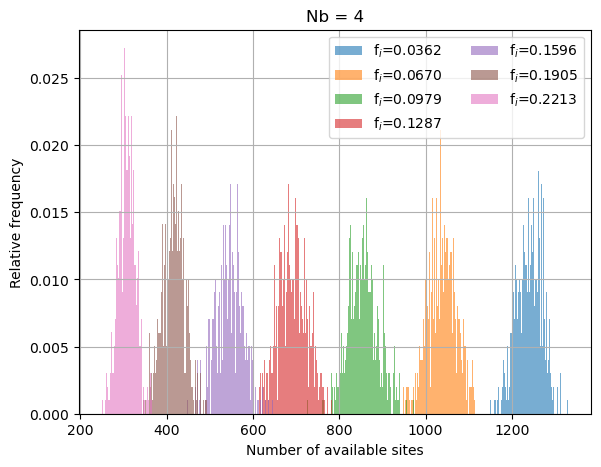

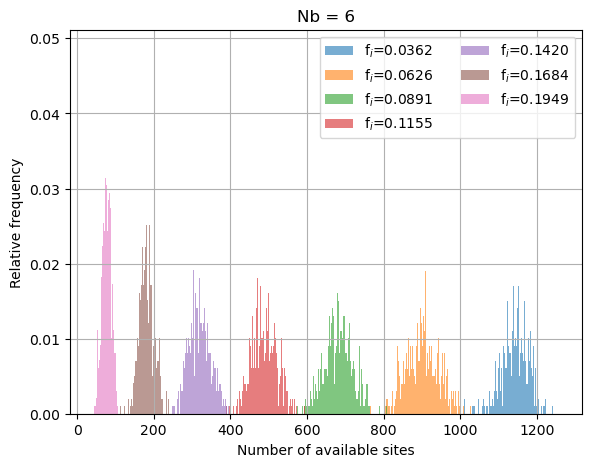

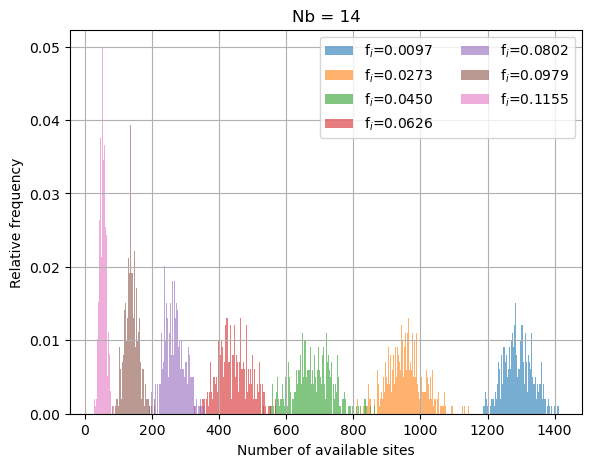

In [62]:
#Available


    
for NN in neighbors:    
    if NN==np.sqrt(2)/4:
        JMAK_nb=4 #nb = 2
        lim_inf=40
        lim_sup = len(count_blocked[NN])-120
        step=35
    if NN==1/2:
        JMAK_nb = 6 # nb = 4
        lim_inf=40
        lim_sup = len(count_blocked[NN])-20
        step=30
    if NN==np.sqrt(6)/4:
        JMAK_nb= 14
        lim_inf=10
        lim_sup = len(count_blocked[NN])-20
        step=20
        
    def funcao(fi):
        return exp(-JMAK_nb*fi)
    
    
    frames = []
    filename = f'distributions_available_nb{JMAK_nb}.png'
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    x = np.arange(0, (len(n_cells_X)*len(n_cells_y)*len(n_cells_z)*12), 0.5)
    
    for fi in list(count_available[NN])[lim_inf:lim_sup:step]:
        dicionario = count_available[NN][fi]
        valores = list(dicionario.values())
        axes.hist(np.array(valores), bins=max(valores)-min(valores)+1,density=True,label=f'f$_i$={fi:.4f}',alpha=0.6)
 
    plt.xlabel('Number of available sites')
    plt.ylabel('Relative frequency')
    plt.title(f'Nb = {JMAK_nb}')
    plt.legend(loc=0,ncol=2)
    axes.grid(True)
    fig.savefig(filename)


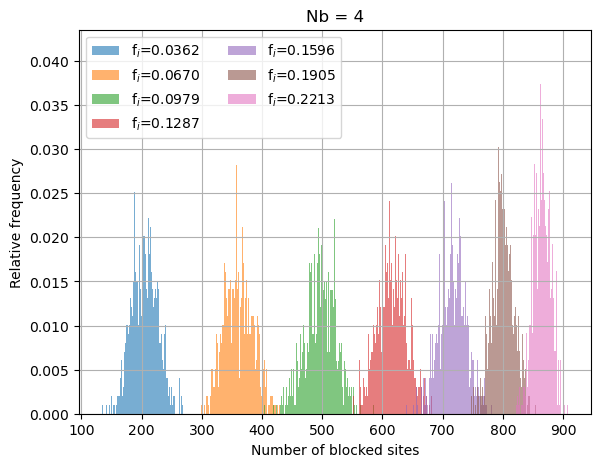

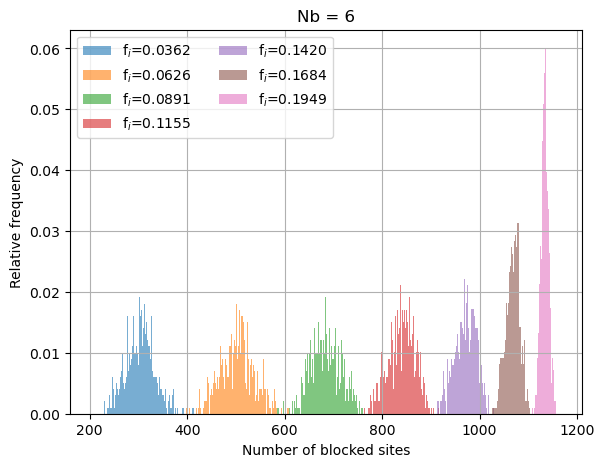

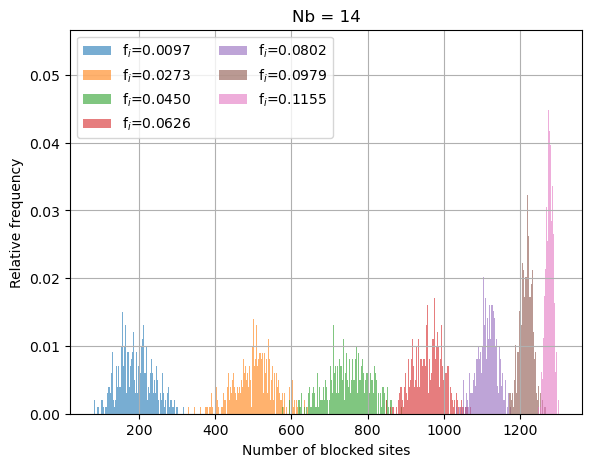

In [64]:
#Blocked


    
for NN in neighbors:    
    if NN==np.sqrt(2)/4:
        JMAK_nb=4 #nb = 2
        lim_inf=40
        lim_sup = len(count_blocked[NN])-120
        step=35
    if NN==1/2:
        JMAK_nb = 6 # nb = 4
        lim_inf=40
        lim_sup = len(count_blocked[NN])-20
        step=30
    if NN==np.sqrt(6)/4:
        JMAK_nb= 14
        lim_inf=10
        lim_sup = len(count_blocked[NN])-20
        step=20
        
    def funcao(fi):
        return exp(-JMAK_nb*fi)
    
    
    frames = []
    filename = f'distributions_blocked_nb{JMAK_nb}.png'
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    #fig = create_frame(t)
    x = np.arange(0, (len(n_cells_X)*len(n_cells_y)*len(n_cells_z)*12), 0.5)
    
    for fi in list(count_blocked[NN])[lim_inf:lim_sup:step]:
        dicionario = count_blocked[NN][fi]
        valores = list(dicionario.values())
        axes.hist(np.array(valores), bins=max(valores)-min(valores)+1,density=True,label=f'f$_i$={fi:.4f}',alpha=0.6)
  
    plt.xlabel('Number of blocked sites')
    plt.ylabel('Relative frequency')
    plt.title(f'Nb = {JMAK_nb}')
    plt.legend(loc=0,ncol=2)
    axes.grid(True)
    fig.savefig(filename)


# Setting Garces model

In [78]:
#AVRAMI MODEL

class Phase:
    def __init__(self,name):
        self.name = name
        self.r = []
        self.theta = []
        self.cH_step = []
        self.cH = []
        self.temperatures = []
        self.n_site_type = [] # 4 for tetrahedral sites, 6 for octahedral sites 
        self.cH_limit = []
        self.S = {}
        self.S_c = {}
        self.mu_H = {}
        self.dSc = {}
        self.mu_M = {}
        self.dS = {}
        self.dS_c = {}
        
        
    @property
    def set_cH_limit(self):   
        self.cH_limit = self.theta/self.r
        
        
        
        
    @property
    def set_cH(self):
        c_H = []
        for i in range(1,int(self.theta/self.cH_step +1)):
            if (self.cH_step*i)< self.cH_limit:
                c_H.append(truncate(self.cH_step*i,4))
        self.cH = np.array(c_H)
        
    
    def s0(self,T):
        if T !=0:
            t=T/1000
            A = 33.066178
            B = -11.363417
            C = 11.432816
            D = -2.772874
            E = -0.158558
            G = 172.707974
            S0 = A*ln(t) + B*t + C*(t**2)/2 + D*(t**3)/3 - E/(2*t**2) + G # Hydrogen standard entropy J/mol of H2- NIST
            S0 = S0/1000 #kJ/mol of H2
            return S0
        else:
            return 0
        
        
    @property
    def calculate_entropy(self):
        for T in self.T:
            if T!=0:
                self.fh = self.cH/self.theta
                self.Pb = (self.r-1)*self.fh
                self.Pv = (1 - self.fh - self.Pb)/(1-self.Pb)
                self.Ph = self.fh/(1-self.Pb)
                self.S_c[T] = -R *self.theta*(1-self.Pb)*(self.Ph*ln(self.Ph)+self.Pv*ln(self.Pv))
                self.S[T] = self.S_c[T] - ((self.cH * self.s0(T))/2)
            else:
                self.S_c[T] = np.zeros(len(self.cH))
                self.S[T] = self.S_c[T]
                self.f[T].append([fh,Pb,Pv])
            
    @property
    def calculate_dSc(self):
        fh = self.cH/self.theta
        for T in self.T:
            self.dSc[T] =  (-R*ln((fh*((1-(self.r-1)*fh)**(self.r-1))/(1-self.r*fh)**self.r)))
           

In [79]:
#Calculating Garces model

######### Nb = 4 ##############
Temperatures = [25+273.15]
garces_T_BCC_1NN = Phase('delta')
garces_T_BCC_1NN.theta = 6
garces_T_BCC_1NN.r = 5
garces_T_BCC_1NN.n_site_type = 4 #occupation of tetrahedral sites
garces_T_BCC_1NN.T = Temperatures
garces_T_BCC_1NN.set_cH_limit
garces_T_BCC_1NN.cH_step = 0.0005
garces_T_BCC_1NN.set_cH
garces_T_BCC_1NN.calculate_entropy
garces_T_BCC_1NN.calculate_dSc

######### Nb = 6 ##############
garces_T_BCC_2NN = Phase('delta')
garces_T_BCC_2NN.theta = 6
garces_T_BCC_2NN.r = 7
garces_T_BCC_2NN.n_site_type = 4 #occupation of tetrahedral sites
garces_T_BCC_2NN.T = Temperatures
garces_T_BCC_2NN.set_cH_limit
garces_T_BCC_2NN.cH_step = 0.0005
garces_T_BCC_2NN.set_cH
garces_T_BCC_2NN.calculate_entropy
garces_T_BCC_2NN.calculate_dSc


######### Nb = 14 ##############
Temperatures = [25+273.15]
garces_T_BCC_3NN = Phase('delta')
garces_T_BCC_3NN.theta = 6
garces_T_BCC_3NN.r = 15
garces_T_BCC_3NN.n_site_type = 4 #occupation of tetrahedral sites
garces_T_BCC_3NN.T = Temperatures
garces_T_BCC_3NN.set_cH_limit
garces_T_BCC_3NN.cH_step = 0.0005
garces_T_BCC_3NN.set_cH
garces_T_BCC_3NN.calculate_entropy
garces_T_BCC_3NN.calculate_dSc

garces_T_BCC = [garces_T_BCC_1NN,garces_T_BCC_2NN,garces_T_BCC_3NN]

# Setting JMAK model parameters

In [80]:
#JMAK FIT MODEL

class Phase_fit:
    def __init__(self,name):
        self.name = name
        self.r = []
        self.theta = []
        self.cH_step = []
        self.cH = []
        self.temperatures = []
        self.n_site_type = [] # 4 for tetrahedral sites, 6 for octahedral sites 
        self.cH_limit = []
        self.S = {}
        self.S_fit = {}
        self.S_c = {}
        self.S_c_fit = {}
        self.occupation_k_site = {}
        self.mu_H = {}
        self.dSc = {}
        self.mu_M = {}
        self.dS = {}
        self.dS_c = {}
        self.dSc_fit = {}
        self.nb = []
        
        
    @property
    def set_cH_limit(self):   
        if self.n == 0:
            self.cH_limit = self.theta/(self.nb+1)
        if self.n !=0:
            def Pb(x):
                fb_extended = (self.nb)*(x/(self.theta)) #JMAK
                return x-self.theta*exp(-fb_extended) 
                
            x0 = 0.005
            bnds = [(0,self.theta)]
            
            cons = {'type': 'eq', 'fun': lambda x: Pb(x),
                           }
            cH_limit = spo.minimize(Pb,x0, options = {"disp": True, "maxiter": 2000}, method = 'SLSQP',  constraints = cons, bounds = bnds)
            self.cH_limit = cH_limit.x
        
        
        
        
    @property
    def set_cH(self):
        c_H = []
        for i in range(1,int(self.theta/self.cH_step +1)):
            if (self.cH_step*i)< self.cH_limit:
                c_H.append(truncate(self.cH_step*i,4))
        self.cH = np.array(c_H)
        
    
    def s0(self,T):
        if T !=0:
            t=T/1000
            A = 33.066178
            B = -11.363417
            C = 11.432816
            D = -2.772874
            E = -0.158558
            G = 172.707974
            S0 = A*ln(t) + B*t + C*(t**2)/2 + D*(t**3)/3 - E/(2*t**2) + G # Hydrogen standard entropy J/mol of H2- NIST
            S0 = S0/1000 #kJ/mol of H2
            return S0
        else:
            return 0
        
        
    @property
    def calculate_entropy(self):
        for T in self.T:
            if T!=0:
                self.fh = self.cH/self.theta
                self.Pb = 1-exp(-(self.nb)*(self.fh))
                self.Pv = (1 - self.fh - self.Pb)/(1-self.Pb)
                self.Ph = self.fh/(1-self.Pb)
                self.S_c[T] = -R *self.theta*(1-self.Pb)*(self.Ph*ln(self.Ph)+self.Pv*ln(self.Pv))
                
        
                
                self.S[T] = self.S_c[T] - ((self.cH * self.s0(T))/2)
            else:
                self.S_c[T] = np.zeros(len(self.cH))
                self.S[T] = self.S_c[T]
                self.f[T].append([fh,Pb,Pv])
            
    @property
    def calculate_dSc(self):
        fh = self.cH/self.theta
        for T in self.T:               
                self.dSc[T] =  (-R*ln((fh*(exp(-(self.nb)*fh))**((self.nb)*exp(-(self.nb)*fh))/(exp(-(self.nb)*fh)-fh)**(1+(self.nb)*exp(-(self.nb)*fh)) )))
            
            
   


# Calculation of 1st, 2nd, and 3rd first NN blocking of T-sites - BCC structure

In [81]:
#Avrami model calculations
Temperatures = [25+273.15]
n = 1
############ Nb=4 ##############
JMAK_T_BCC_1NN = Phase_fit('alpha')                           #name the phase: alpha, beta or delta
JMAK_T_BCC_1NN.theta = 6                                  #configurational entropy parameter: quantity of interstitial sites per metal atom
JMAK_T_BCC_1NN.r = 5                                  #configurational entropy parameter: site blocking effect
JMAK_T_BCC_1NN.nb = 4
JMAK_T_BCC_1NN.n_site_type = 4                            #occupation of tetrahedral sites
JMAK_T_BCC_1NN.n = n                                   #set the blocking model n = 0 for Garces, n=1 Avrami with ve linear, n = 4 avrami with ve 3D
JMAK_T_BCC_1NN.T = Temperatures
JMAK_T_BCC_1NN.set_cH_limit                               #set the Hydrogen composition limit for the phase
JMAK_T_BCC_1NN.cH_step = 0.0005                           #set the step variation in the Hydrogen composition for the termodynamic calculation
JMAK_T_BCC_1NN.set_cH                                     #set all Hydrogen composition possible for the phase
JMAK_T_BCC_1NN.calculate_entropy
JMAK_T_BCC_1NN.calculate_dSc
########## Nb=6 ##############
JMAK_T_BCC_2NN = Phase_fit('beta')
JMAK_T_BCC_2NN.theta = 6
JMAK_T_BCC_2NN.r = 7 
JMAK_T_BCC_2NN.nb = 6
JMAK_T_BCC_2NN.n_site_type = 4 #occupation of tetrahedral sites
JMAK_T_BCC_2NN.n = n
JMAK_T_BCC_2NN.T = Temperatures
JMAK_T_BCC_2NN.set_cH_limit
JMAK_T_BCC_2NN.cH_step = 0.0005
JMAK_T_BCC_2NN.set_cH
JMAK_T_BCC_2NN.calculate_entropy
JMAK_T_BCC_2NN.calculate_dSc
######### Nb = 14 ##############
JMAK_T_BCC_3NN = Phase_fit('delta')
JMAK_T_BCC_3NN.theta = 6
JMAK_T_BCC_3NN.r = 15
JMAK_T_BCC_3NN.nb = 14
JMAK_T_BCC_3NN.n_site_type = 4 #occupation of tetrahedral sites
JMAK_T_BCC_3NN.n = n 
JMAK_T_BCC_3NN.T = Temperatures
JMAK_T_BCC_3NN.set_cH_limit
JMAK_T_BCC_3NN.cH_step = 0.0005
JMAK_T_BCC_3NN.set_cH
JMAK_T_BCC_3NN.calculate_entropy
JMAK_T_BCC_3NN.calculate_dSc

JMAK_T_BCC = [JMAK_T_BCC_1NN,JMAK_T_BCC_2NN,JMAK_T_BCC_3NN]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.822239362210155e-07
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.948397164776907e-12
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.237935978870013e-08
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 6


/tmp/ipykernel_15099/378131043.py:7: RuntimeWarning: divide by zero encountered in log
  return -R*6*(1-fb)*(Pi*ln(Pi)+Pv*ln(Pv))
/tmp/ipykernel_15099/378131043.py:7: RuntimeWarning: invalid value encountered in multiply
  return -R*6*(1-fb)*(Pi*ln(Pi)+Pv*ln(Pv))


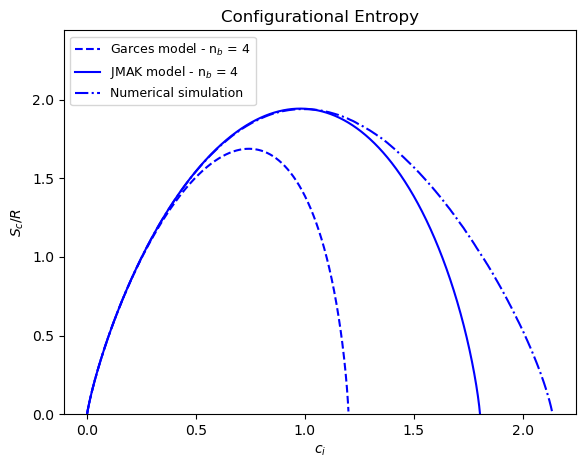

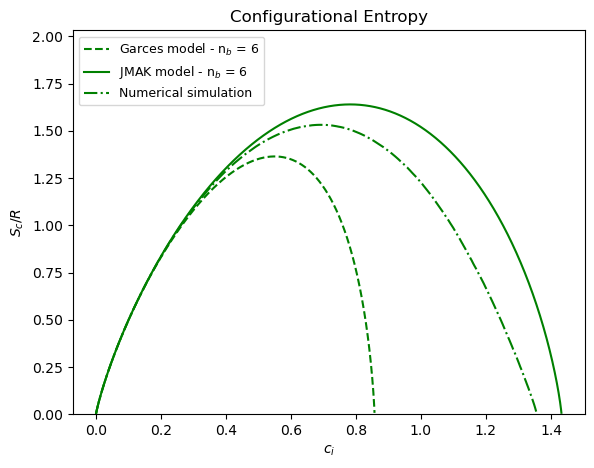

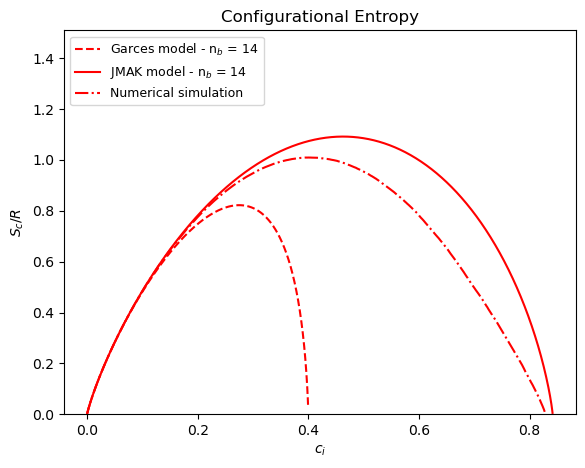

In [88]:
from scipy.optimize import curve_fit
def JMAK_BCC_T(x,Nb):
    return 1-exp(-Nb*x)
def S_C(fi,fv,fb):
    Pi=fi/(1-fb)
    Pv=fv/(1-fb)
    return -R*6*(1-fb)*(Pi*ln(Pi)+Pv*ln(Pv))
    
T = Temperatures[0]    
co = ['blue','green','red']
i=0
for NN in data_f_T_BCC.keys():
    
    if NN==np.sqrt(2)/4:
        JMAK_nb=4 #nb = 2
    if NN==1/2:
        JMAK_nb = 6 # nb = 4
    if NN==np.sqrt(6)/4:
        JMAK_nb= 14

    nb = JMAK_nb
    
    f_i= np.array(data_f_T_BCC[NN][0])
    f_b= np.array(data_f_T_BCC[NN][1])
    f_v = 1-f_i-f_b
    
    
    my_file = f'config_S_BCC_T_{nb}'
    fig = plt.figure()

    # Add set of axes to figure
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    
      

    #plot JMAK model
    axes.plot(JMAK_T_BCC[i].cH,JMAK_T_BCC[i].S_c[T]/R,color = co[i])
    
    
    
    #plot Garces Model
    axes.plot(garces_T_BCC[i].cH,garces_T_BCC[i].S_c[T]/R,color = co[i], ls='--')
    
    #plot Numerical simulation results
    axes.plot(f_i*6,S_C(f_i,f_v,f_b)/R, ls= "-.", color = co[i])
    

    axes.plot([],[],linestyle ='--', color = co[i], label = f'Garces model - n$_b$ = {nb}')
    axes.plot([],[], color = co[i], label = f'JMAK model - n$_b$ = {nb}')
    axes.plot([],[], color = co[i], label = f'Numerical simulation', ls= '-.')
    axes.set_ylabel(f'$S_c/R$')
    axes.set_xlabel(f'$c_i$')
    axes.set_title(f'Configurational Entropy')
    axes.legend(loc='upper left',ncol=1, fontsize = 9)
    plt.ylim(0,max(S_C(f_i,f_v,f_b)/R)+0.5)
    #fig.savefig(os.path.join(my_path, my_file), dpi=200, bbox_inches='tight')
    i=i+1


# Experimental data

In [94]:
#Importing data extracted from Veleckis article plots

for diretorio, subpastas, arquivos in os.walk(pasta):
    for arquivo in arquivos:
        if '.csv' in arquivo:
            if arquivo[0:-10] in data.keys():
                None
            else:
                data[arquivo[0:-10]] = {}

for diretorio, subpastas, arquivos in os.walk(pasta):
    for arquivo in arquivos:
        if '.csv' in arquivo:
            data[arquivo[0:-10]][float(arquivo[-9:-4])+273.15] = pd.read_csv(os.path.join(diretorio, arquivo), sep = ';',decimal=",", names=('cH', 'sqrtP(torr)'), dtype={'cH':float, 'sqrtP(torr)': float},skiprows=2).to_numpy()
            print(os.path.join(diretorio, arquivo))
             
for element in data.keys():            
    for T in data[element].keys():
        for i in np.where(np.unique(data[element][T][0:,0],return_counts=True)[1]>1)[0]:
            data[element][T] = np.delete(data[element][T],i,axis=0)
            
            
            

/home/dell/Anaconda/Experimental_data/Ta_630.6.csv
/home/dell/Anaconda/Experimental_data/Nb_376.2.csv
/home/dell/Anaconda/Experimental_data/Nb_671.0.csv
/home/dell/Anaconda/Experimental_data/V_245.6.csv
/home/dell/Anaconda/Experimental_data/Nb_479.9.csv
/home/dell/Anaconda/Experimental_data/Ta_399.8.csv
/home/dell/Anaconda/Experimental_data/Nb_352.5.csv
/home/dell/Anaconda/Experimental_data/Ta_550.4.csv
/home/dell/Anaconda/Experimental_data/Ta_425.7.csv
/home/dell/Anaconda/Experimental_data/Nb_499.9.csv
/home/dell/Anaconda/Experimental_data/V_368.6.csv
/home/dell/Anaconda/Experimental_data/Nb_419.9.csv
/home/dell/Anaconda/Experimental_data/Ta_376.2.csv
/home/dell/Anaconda/Experimental_data/Nb_544.8.csv
/home/dell/Anaconda/Experimental_data/V_554.0.csv
/home/dell/Anaconda/Experimental_data/Nb_399.8.csv
/home/dell/Anaconda/Experimental_data/Nb_459.9.csv
/home/dell/Anaconda/Experimental_data/V_289.9.csv
/home/dell/Anaconda/Experimental_data/V_309.0.csv
/home/dell/Anaconda/Experimental_dat

In [95]:
#Data from Veleckis article tables


#Enthalpy
H_V_data =[6.93,7.00,7.03,7.15,7.23,7.32,7.38,7.46,7.52,7.58,7.61,7.68,7.75,7.79,7.85,7.91,7.98,8.02,8.06,8.10,8.14,8.19,8.25,8.30,8.38,8.45,8.52,8.59,8.62,8.62,8.61,8.64,8.49,8.40,8.39]
H_Nb_data=[8.44,8.57,8.65,8.69,8.73,8.78,8.81,8.90,8.97,9.04,9.15,9.22,9.28,9.34,9.41,9.48,9.54,9.61,9.69,9.74,9.80,9.88,9.95,10.04,10.11,10.18,10.23,10.30,10.35,10.44,10.52,10.59,10.68,10.75,10.83,10.87,10.92,10.95,10.97,10.98]
H_Ta_data=[8.05,8.11,8.15,8.25,8.30,8.36,8.41,8.47,8.52,8.58,8.66,8.72,8.76,8.80,8.81,8.82,8.86,8.90,8.96,8.99,9.03,9.07,9.11,9.18,9.28,9.32,9.34,9.34]

#Data of the article is in mol of H2


H_V = np.zeros((len(H_V_data),2))
H_Nb = np.zeros((len(H_Nb_data),2))
H_Ta = np.zeros((len(H_Ta_data),2))

H_V[0:,0] = np.arange(len(H_V_data))/100 #setting cH vector as in the table
H_V[0:,1] = np.array(H_V_data)/2 #conversion mol of H2 -> mol of H
H_Nb[0:,0] = np.arange(len(H_Nb_data))/100
H_Nb[0:,1] = np.array(H_Nb_data)/2
H_Ta[0:,0] = np.arange(len(H_Ta_data))/100
H_Ta[0:,1] = np.array(H_Ta_data)/2  



#Entropy
R_article = 1.987
S_V_data= [4.33,5.94,6.89,7.54,8.07,8.50,8.89,9.21,9.51,9.77,10.00,10.25,10.45,10.67,10.88,11.10,11.26,11.43,11.59,11.77,11.94,12.14,12.31,12.55,12.78,13.02,13.28,13.47,13.64,13.80,13.90,14.05,14.17,14.44]
S_Nb_data=[4.91,6.36,7.18,7.77,8.23,8.61,8.99,9.30,9.60,9.92,10.17,10.38,10.59,10.79,10.99,11.16,11.34,11.53,11.69,11.84,12.02,12.18,12.37,12.53,12.68,12.83,12.99,13.13,13.32,13.51,13.70,13.92,14.13,14.36]
S_Ta_data = [4.74,6.16,7.08,7.70,8.20,8.62,8.99,9.31,9.62,9.93,10.21,10.43,10.64,10.81,10.98,11.17,11.36,11.57,11.74,11.94,12.13,12.32,12.56,12.84,13.00,13.24,13.42]

S_V = np.zeros((len(S_V_data),2))
S_Nb = np.zeros((len(S_Nb_data),2))
S_Ta = np.zeros((len(S_Ta_data),2))

S_V[0:,0] = np.arange(len(S_V_data))/100
S_V[0:,1] = np.array(S_V_data)/2
S_Nb[0:,0] = np.arange(len(S_Nb_data))/100
S_Nb[0:,1] = np.array(S_Nb_data)/2
S_Ta[0:,0] = np.arange(len(S_Ta_data))/100
S_Ta[0:,1] = np.array(S_Ta_data)/2

In [96]:
# Pressure to adimentional

Nb_SI ={}
V_SI= {}
Ta_SI = {}


torr_Pa = 133.322
p0= 101325


for element in data.keys():
    for T in data[element]:
        data[element][T][0:,1]= (data[element][T][0:,1]**2)*torr_Pa/p0
        

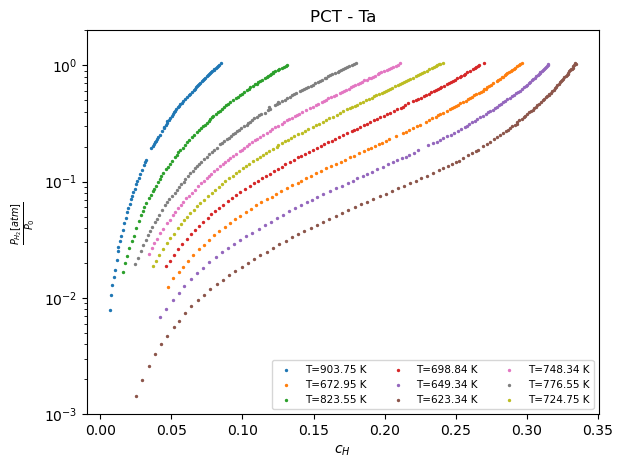

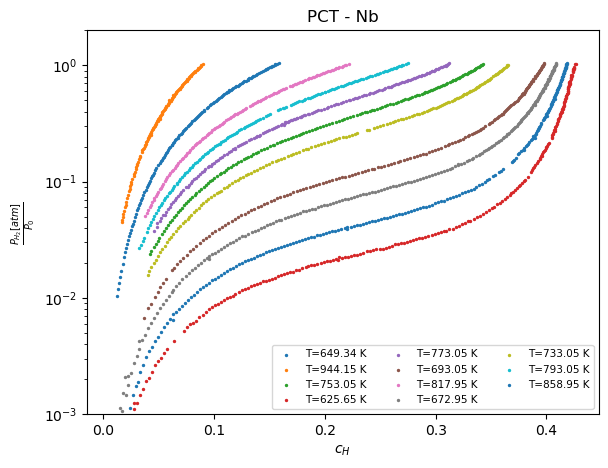

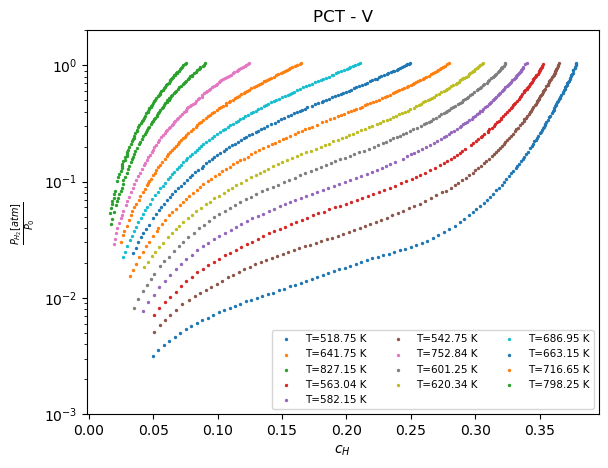

In [99]:
#Plot PCTs

for element in data.keys():
    my_file= f'PCT_{element}'
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    for i in data[element]:
        axes.scatter(data[element][i][0:,0],data[element][i][0:,1],s=2,label = f'T={truncate(i,2)} K')
    axes.set_xlabel('$c_H$') 
    axes.set_ylabel(r"$\frac{P_{H_{2}}[atm]}{P_0}$ ")
    axes.set_title(f"PCT - {element}")
    axes.set_yscale('log')
    axes.set_ylim([10**-3,2])
    axes.legend(loc=0,ncol=3, fontsize='7.5')
    fig.savefig(os.path.join(my_path, my_file), dpi=200, bbox_inches='tight')

In [100]:
#Determination of partial molar enthalpy and entropy from PCTs

data_Sc={}
data_config = {}
H={}
S={}
data_P ={}
mesh_points = 100000
step = int(0.05*mesh_points)
for element in data.keys():
    data_Sc[element]= {}
    data_config[element]= {}
    H[element]=[]
    S[element] =[]
    data_P[element]={}
    for cH in range(0,int(max(data[element][min(data[element].keys())][0:,0])*mesh_points),step):
        cH=cH/100000

        temp=[]
        for T in data[element].keys():
            try:
                idx = np.where(abs(data[element][T][0:,0]-cH)<0.002)[0][0]
                temp.append([T,data[element][T][idx,1]])
            except:
                None
            data_P[element][cH]=np.array(temp)
        if len(temp)>2:  
            x=1/(np.array(temp)[0:,0])
            y=ln(np.array(temp)[0:,1])

            (slope, intercept, r_value, p_value, std_err) = linregress(x, y)

            dH_temp = slope*R/2
            dS_temp = intercept*R/2




            H[element].append([cH,dH_temp])
            S[element].append([cH,dS_temp])
   
    H[element]= np.array(H[element])
    S[element]= np.array(S[element])

In [101]:
#removing outlier in vanadium data

H['V'] = np.delete(H["V"],6,axis=0) 
S['V'] = np.delete(S["V"],6,axis=0)

/tmp/ipykernel_15099/1157028603.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  paleta_cores = plt.cm.get_cmap('Dark2')


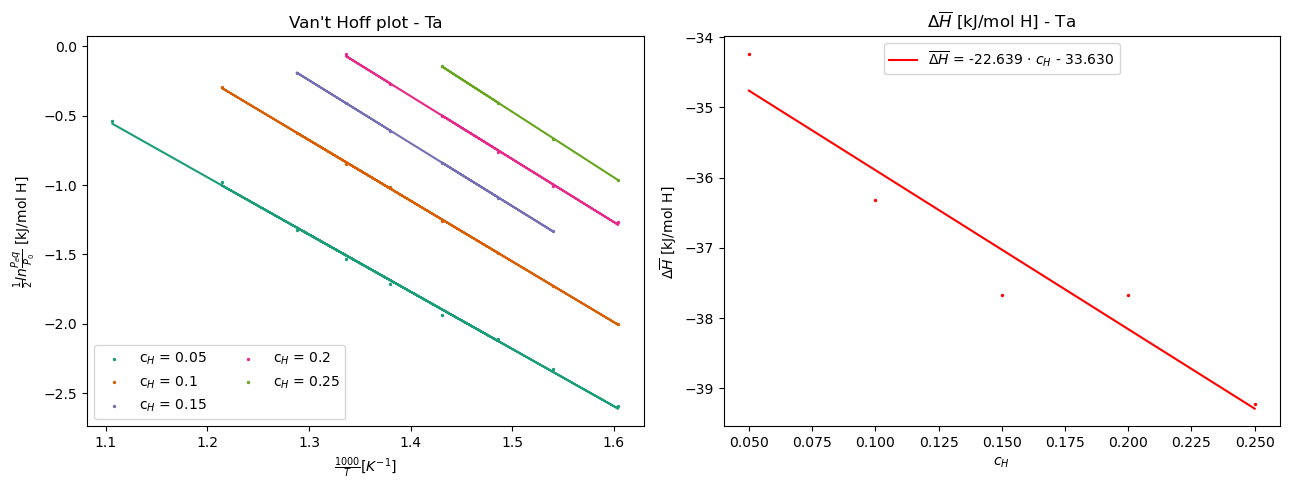

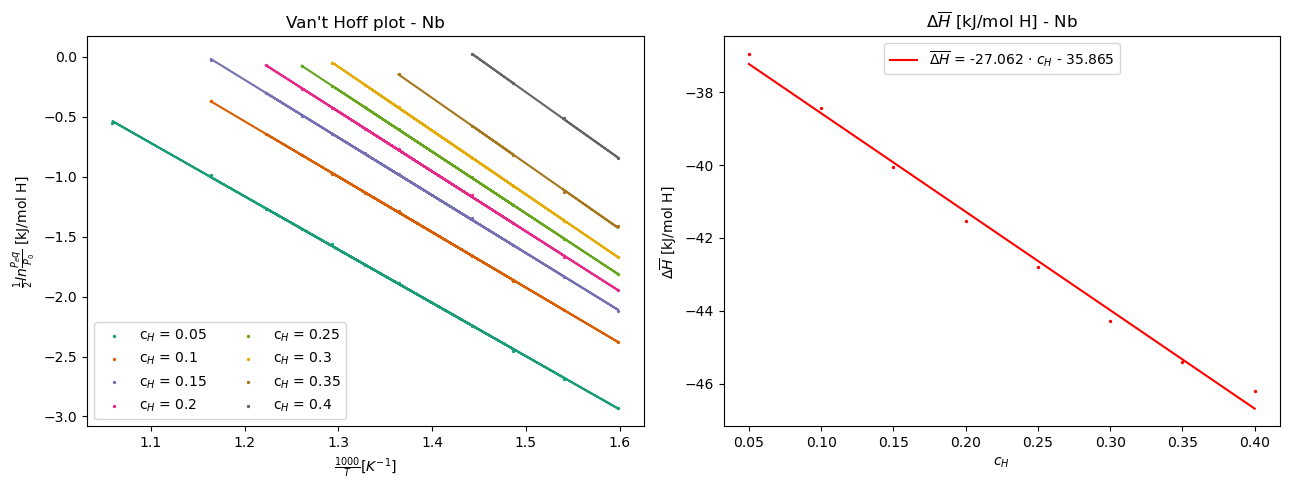

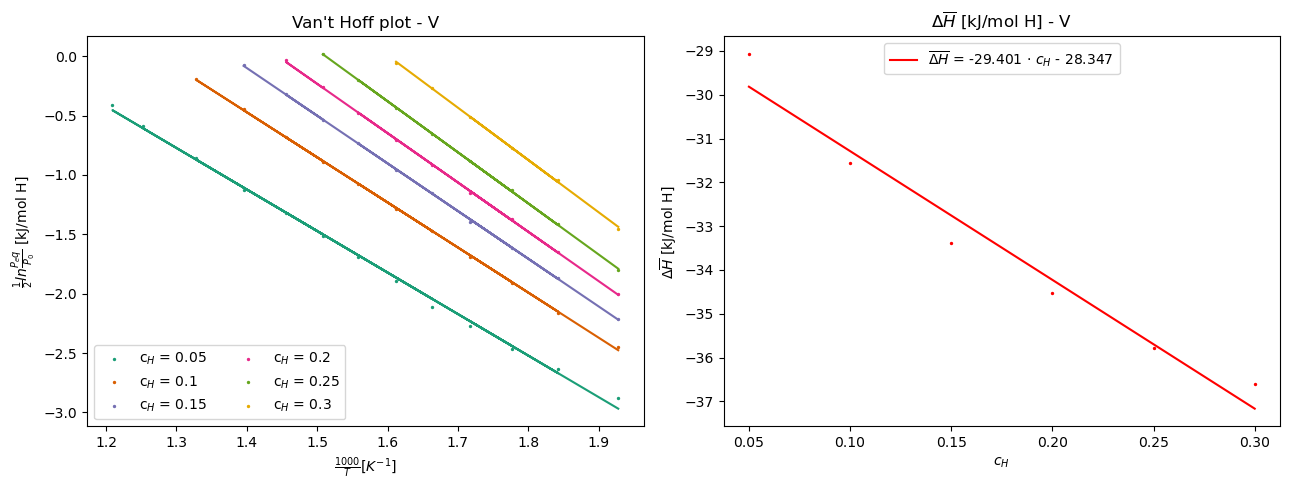

In [102]:
#Van`t Hoff plot and determination of partial molar enthalpy as function of hydrogen composition

coeff={}
for element in H:
    x=H[element][0:,0]
    y=H[element][0:,1]

    (slope, intercept, r_value, p_value, std_err) = linregress(x, y)
    coeff[element]=(slope,intercept)

def line(a,b,x):
    return a*x+b

def vant_hoff(h,s,x):
    return h*(x/1000) + s

import random

for element in data.keys():
    
    # setting colors palette
    paleta_cores = plt.cm.get_cmap('Dark2') 
    cores = [paleta_cores(_) for _ in range(len(H[element][0:,0]))] 
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cores)


    
    
    my_file = f'vant_hoff_H_{element}'
    fig, axs = plt.subplots(1, 2,  figsize=(13,5))
    for cH in H[element][0:,0]:
        if cH>0:
            idx = np.where(H[element][0:,0]==cH)[0]   
            x = 1000/data_P[element][cH][0:,0] 
            h=H[element][idx,1]/R
            s=S[element][idx,1]/R
            y= ln(data_P[element][cH][0:,1])/2
            
            axs[0].scatter(x, y,s=2, label = f"c$_H$ = {cH}") # experimental data
            
            
            y=vant_hoff(h,s,x)
            axs[0].plot(x,y)  #linear regression/Van't hoff plot
            
            
        axs[0].set_title(f"Van't Hoff plot - {element}")
        axs[0].set_xlabel(r'$\frac{1000}{T} [K^{-1}]$') 
        axs[0].set_ylabel(r"$\frac{1}{2} ln \frac{P_eq}{P_0}$ [kJ/mol H] ")
        axs[0].legend(loc=0,ncol = 2, fontsize = '10')
    
    x= H[element][0:,0]
    a=coeff[element][0]
    b=coeff[element][1]
    y= H[element][0:,1]
    
    c='red'
    axs[1].scatter(x, y,s=2,color= c)
    
    
    y= line(a,b,x)
    axs[1].plot(x, y,color =c, label = r'$\overline{\Delta H}$ = ' +f'{a:.3f} $\cdot$ $c_H$ - {abs(b):.3f}')
   
    
    
    
    axs[1].set_xlabel('$c_H$')
    axs[1].set_ylabel(r"$\Delta \overline{H}$ [kJ/mol H] ")
    axs[1].set_title(r"$\Delta  \overline{H}$ [kJ/mol H]" + f' - {element}')
    axs[1].legend(loc=9)
    

    fig.tight_layout()
    fig.savefig(os.path.join(my_path, my_file), dpi=200, bbox_inches='tight')

In [110]:
#organizing Configurational entropy for experimental data

for element in data.keys():
    H[element] = np.array(H[element])
    for T in data[element].keys():
        x= data[element][T][0:,0]
        a=coeff[element][0]
        b=coeff[element][1]
        
        
        data_Sc[element][T] = np.zeros((len(x),2))
        data_Sc[element][T][0:,0] = np.array(x)


        data_Sc[element][T][0:,1] =  (line(a,b,x)/((float(T)))) - (R*ln(data[element][T][0:,1])/2)


/tmp/ipykernel_15099/3538109946.py:2: RuntimeWarning: divide by zero encountered in divide
  return ln(((6-4*cH)**2)/((6-cH)*cH))
/tmp/ipykernel_15099/3538109946.py:5: RuntimeWarning: divide by zero encountered in divide
  return ln(((6-5*cH)**4)*(6-4*cH)/(((6 - 2*cH)**3)*(6 - 3*cH)*cH))


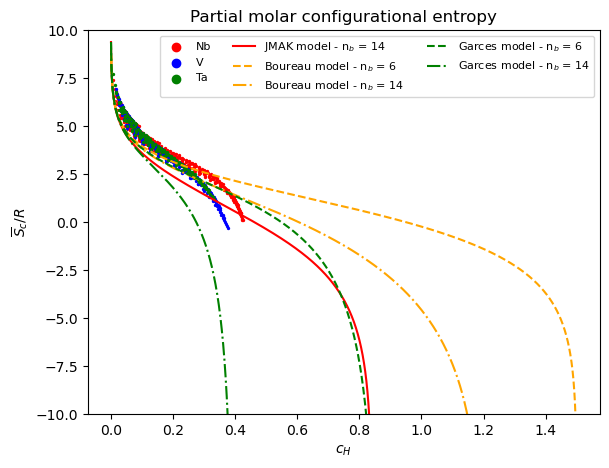

In [115]:
def boureau_2NN(cH):
    return ln(((6-4*cH)**2)/((6-cH)*cH))

def boureau_3NN(cH):
    return ln(((6-5*cH)**4)*(6-4*cH)/(((6 - 2*cH)**3)*(6 - 3*cH)*cH))

my_file = f'Comparison_config_partial_molar.png'
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 

c=['red','blue','green']
i=0

for element in ['Nb', 'V','Ta']:
    #experimental data
    for T in data_Sc[element]:
        x=np.array([data_Sc[element][T][idx,0] for idx in range(0,len(data_Sc[element][T][0:,0]),6)])
        y=np.array([data_Sc[element][T][idx,1] for idx in range(0,len(data_Sc[element][T][0:,1]),6)])
        axes.scatter(x,(y+s0(T)/2)/R,s=2,color = c[i])
    axes.scatter([],[],color = c[i], label = f'{element}')
    i=i+1
    
#Jmak model
axes.plot(JMAK_T_BCC_3NN.fh*JMAK_T_BCC_3NN.theta,JMAK_T_BCC_3NN.dSc[25+273.15]/R,linestyle='-',c='red',label = f'JMAK model - n$_b$ = 14')
    

#Boureau
axes.plot(np.arange(0,1.5,0.001), boureau_2NN(np.arange(0,1.5,0.001)),ls='--' , c= 'orange', label = f'Boureau model - n$_b$ = 6')
axes.plot(np.arange(0,1.2,0.001), boureau_3NN(np.arange(0,1.2,0.001)),ls='-.' , c= 'orange', label = f'Boureau model - n$_b$ = 14')

    

    
#Garces
axes.plot(garces_T_BCC_2NN.fh*garces_T_BCC_2NN.theta, (garces_T_BCC_2NN.dSc[25+273.15])/R,ls='--' , c= 'green', label = f'Garces model - n$_b$ = 6')
axes.plot(garces_T_BCC_3NN.fh*garces_T_BCC_3NN.theta, (garces_T_BCC_3NN.dSc[25+273.15])/R,ls='-.' , c= 'green', label = f'Garces model - n$_b$ = 14')





axes.set_xlabel('$c_H$') 
axes.set_ylabel(r"$\overline{S}_c/R$")
axes.set_title(f'Partial molar configurational entropy')
axes.legend(loc = 0,ncol=3,fontsize = 8)
#axes.set_xlim([0,0.9])
axes.set_ylim([-10,10])
#axes.invert_yaxis()
fig.savefig(os.path.join(my_path, my_file), dpi=200, bbox_inches='tight')


